<a href="https://colab.research.google.com/github/lisaqhou4/ML_final_project/blob/main/Sentimental_Anlysis_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 3.9 MB/s 


In [2]:
!pip install -qq transformers

     |████████████████████████████████| 5.8 MB 4.3 MB/s 
ERROR: Operation cancelled by user


In [ ]:
pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=850984c9acf909c9ce8f3b338ecd4126670e7ccf2dfa6291b6bcad9c4f8e2ace
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.13.0+cu116
transformers: 4.25.1



In [5]:
#import transformers
#from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
import re
#import emoji 

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df = pd.read_csv("/content/drive/MyDrive/cleaned_sample.csv")
df.set_axis(["Text", "Label"], axis=1,inplace=True)
df = df.rename(columns={"content": "Text", "label": "Label"})
df = df[df["Label"].str.contains("IC") == False]
df = df.dropna(axis=0, how='any')

FileNotFoundError: ignored

In [ ]:
len(df.Label)

829

In [ ]:
df.head(10)

,Unnamed: 0,Text,Label
0,0,"Our FAVORITE Herbal Reference Book, Great 4 Bo...",positive
1,1,Studying Ayurvedic herbal medicine &gt;&gt;&gt;,neutral
2,2,"Learn the Principles of Herbal Medicine, Tissu...",neutral
3,3,Excuse me for interrupting. I thought the same...,neutral
4,4,Very interesting @iamritu.\n Tongxinluo\n \n H...,positive
5,5,"https://t.co/D8oNwxqZgK\n \n For example, the ...",neutral
6,6,Check it out! Apothecary At Home is a monthly ...,neutral
7,7,Chinese Herbal Medicine for Beginners: Over 10...,neutral
8,8,I’m super proud of myself. I’m learning herbal...,positive
9,9,many happy returns. here is a bag of herbal me...,positive


Total hashtags:  357
Repeated hashtags:  275


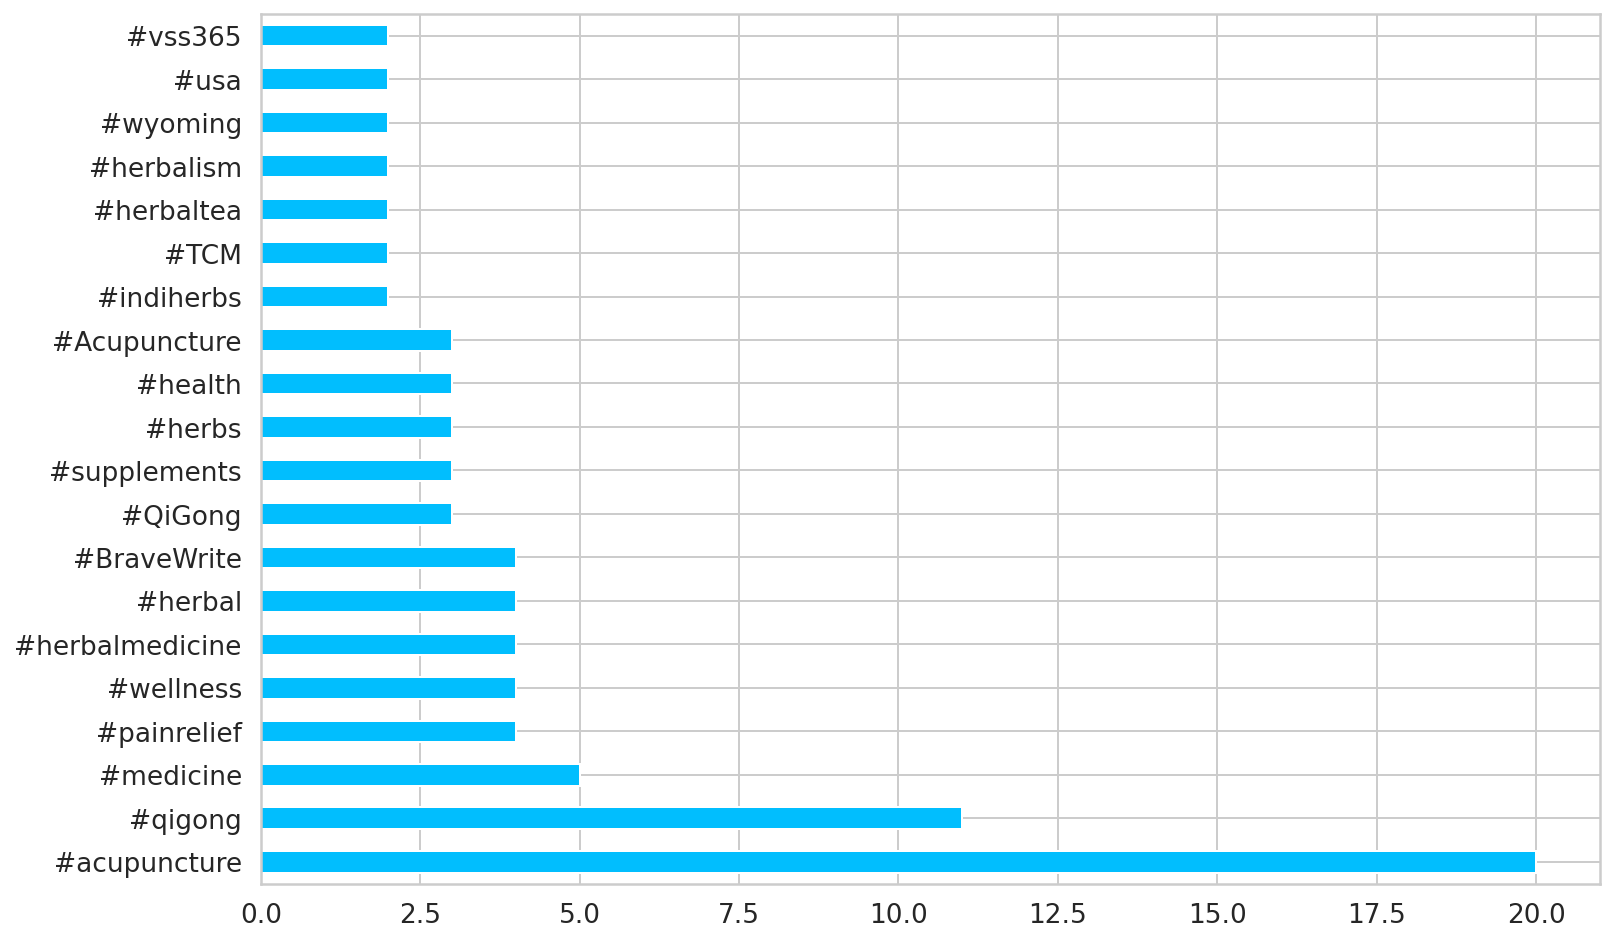

In [ ]:
def find_hashtags(tweet):
  return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
df['hashtag'] = df.Text.apply(find_hashtags)

hashtag_list = df['hashtag'].to_list()
flat_hashtags_df = pd.DataFrame([item for sublist in hashtag_list for item in sublist])
flat_hashtags_df.shape
#change the name of the column to hashtags
flat_hashtags_df.columns = ['hashtag']
flat_hashtags_df.head()
print("Total hashtags: ", len(flat_hashtags_df['hashtag']))
print("Repeated hashtags: ", len(flat_hashtags_df['hashtag'].unique()))
flat_hashtags_df['hashtag'].value_counts()[:20].plot(kind='barh');

In [ ]:
def clean(tweet):
  txt = re.sub(r"https?://\S+", "", tweet) #remove hyperlink
  txt =re.sub("\n", " ", txt)
  txt =re.sub(":", " ", txt)
  txt =re.sub(r"&amp", " ", txt)
  txt = re.sub(r'@[A-Za-z0-9_]+[A-Za-z0-9-_]+', '', txt) #remove mention
  txt = re.sub(r'#[A-Za-z]+[A-Za-z0-9-_]+', '', txt)
  txt = re.sub("_", " ", txt)
  txt = emoji.replace_emoji(txt, replace='')
  return txt

df.Text = df.Text.apply(clean)

In [ ]:
numLabel = []
for label in df.Label:
  if label == "positive" or label == "P":
    numLabel.append(0)
  elif label == "neutral" or label == "NE":
    numLabel.append(1)
  else:
    numLabel.append(2)
df["num_label"] = numLabel

In [ ]:
from google.colab import files
file_name = 'apunctured_clean.xlsx'
df.to_excel(file_name)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sentiment Count')

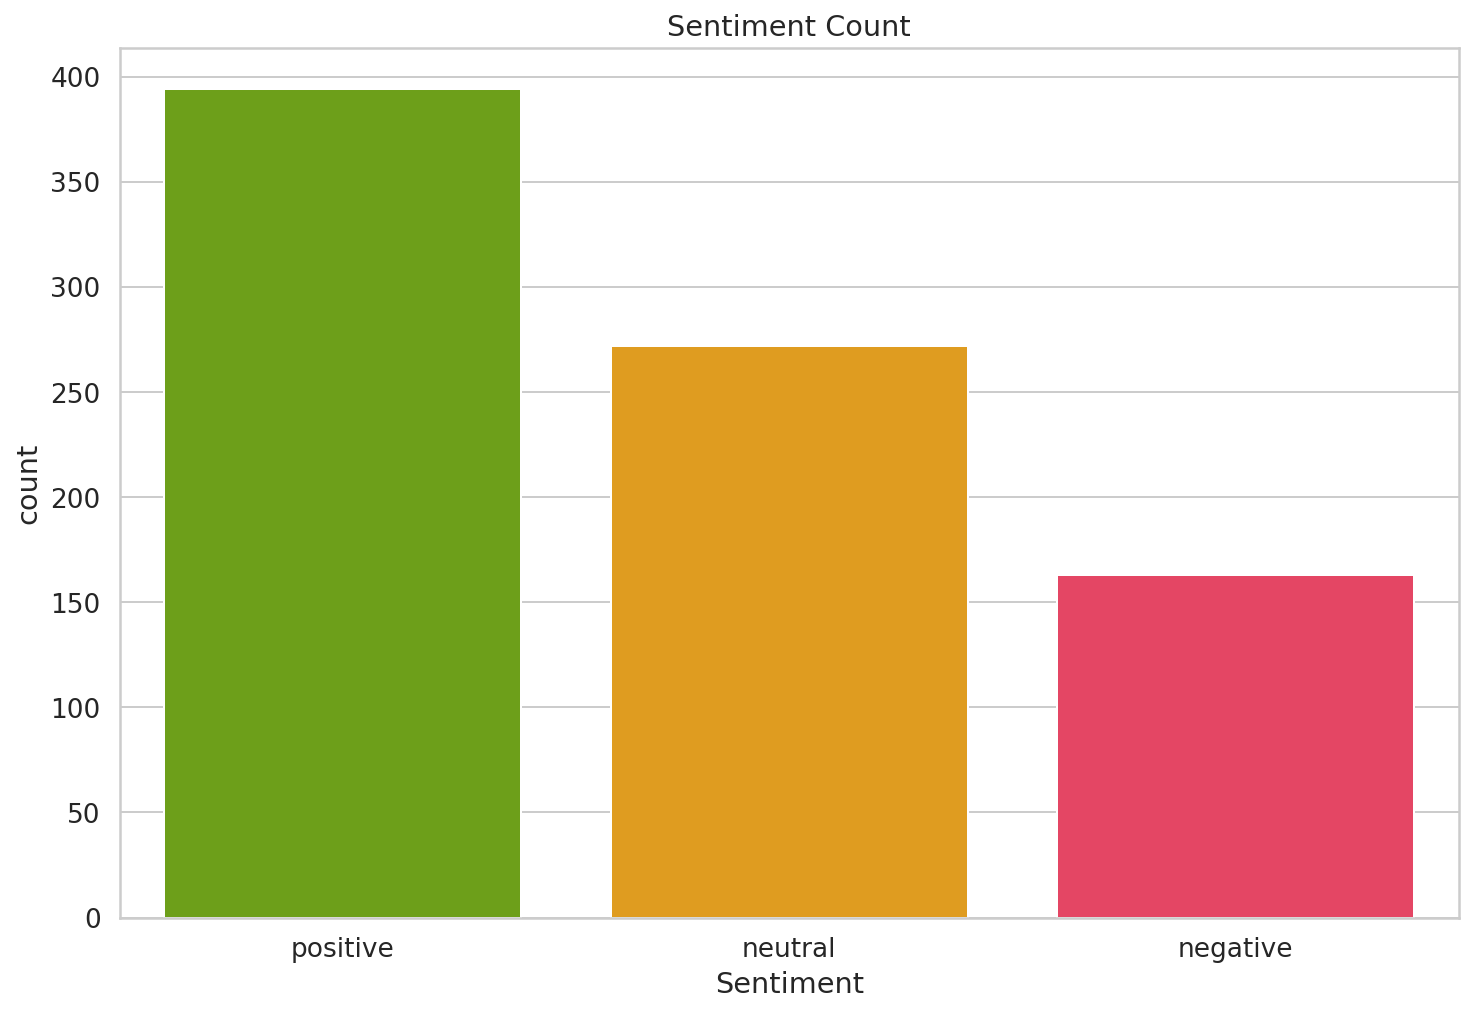

In [ ]:
sns.countplot(df.num_label,  palette=['#73b504',"#ffa500", '#Fe2c54'])
plt.xticks([0, 1, 2],['positive','neutral','negative'])
plt.xlabel('Sentiment');
plt.title("Sentiment Count")

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=1000)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


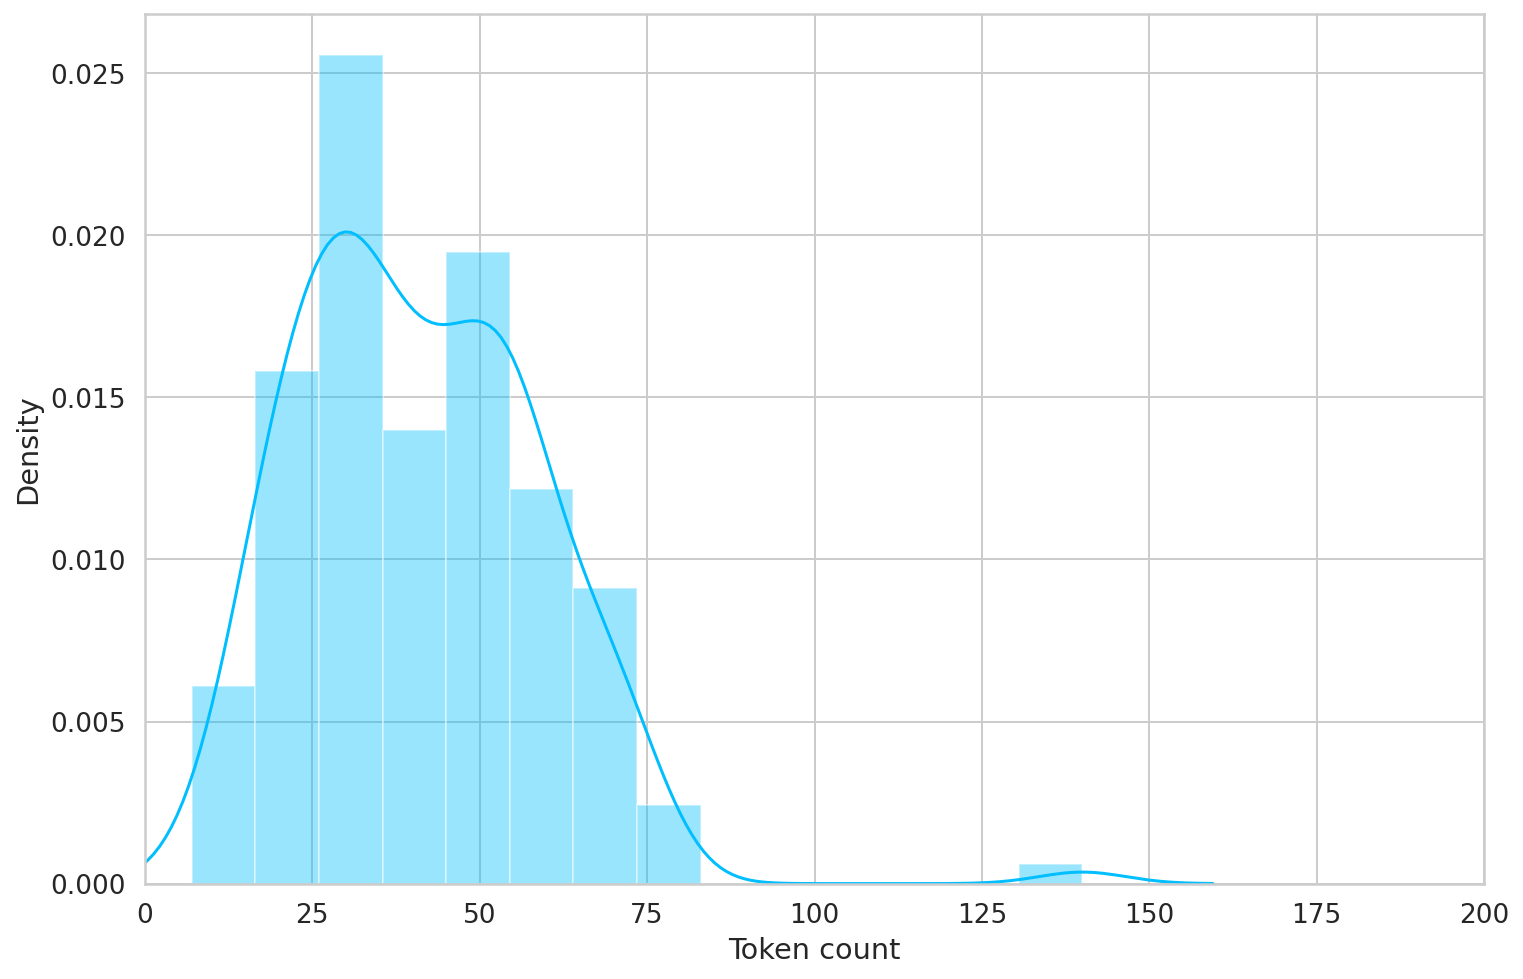

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 200

In [ ]:
class GPTweetDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'texts': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((155, 4), (9, 4), (9, 4))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPTweetDataset(
    texts=df.Text.to_numpy(),
    targets=df.num_label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['texts', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])
